<br>**Заказчик исследования:** стартап, который продаёт продукты питания. 
<br>**Цель исследования:** разобраться, как ведут себя пользователи мобильного приложения. 


Для достижения поставленных целей необходимо выполнить следующие этапы исследования:
<br>
1. Провести подготовку полученных данных
2. Проанализировать данные
3. Изучить воронку продаж
4. Исследовать результаты A/A/B-эксперимента по изменению шрифта в приложении
5. Сформулировать выводы и разработать рекомендации


# 1. Подготовка данных

In [1]:
import pandas as pd  
from matplotlib import pyplot as plt
import math as mth
import numpy as np
import plotly.express as px
from plotly import graph_objects as go
from scipy import stats as st
import seaborn as sns

In [2]:
try:
    data = pd.read_csv('logs_exp.csv', sep = "\t")  # загружаем локальный файл с данными
except:
    data = pd.read_csv('/datasets/logs_exp.csv', sep = "\t")   # альтернативный пусть к данным для работы с других устройств

Смотрим общую информацию о датасете:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Переименуем столбцы датасета в более удобные для анализа

In [5]:
data.columns = ['event_name', 'user_id', 'event_timestamp', 'group']

Переименуем также названия групп тестирования и названия событий в более удобные для прочтения и дальнейшего анализа:

In [6]:
data['group'] = data['group'].replace(246, 'A1')
data['group'] = data['group'].replace(247, 'A2')
data['group'] = data['group'].replace(248, 'B')

In [7]:
data['event_name'] = data['event_name'].replace('MainScreenAppear', 'Main screen')
data['event_name'] = data['event_name'].replace('PaymentScreenSuccessful', 'Payment screen')
data['event_name'] = data['event_name'].replace('CartScreenAppear', 'Cart screen')
data['event_name'] = data['event_name'].replace('OffersScreenAppear', 'Offers screen')

Приведем к соответствующему формату столбец с временем события и добавим столбец с информацией только даты :

In [8]:
data['event_time']= pd.to_datetime(data['event_timestamp'], unit = 's')

In [9]:
data['event_date']= pd.to_datetime(data['event_time']).dt.normalize()

In [10]:
data.head()

,event_name,user_id,event_timestamp,group,event_time,event_date
0,Main screen,4575588528974610257,1564029816,A1,2019-07-25 04:43:36,2019-07-25
1,Main screen,7416695313311560658,1564053102,A1,2019-07-25 11:11:42,2019-07-25
2,Payment screen,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
3,Cart screen,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
4,Payment screen,6217807653094995999,1564055322,B,2019-07-25 11:48:42,2019-07-25


Проверим датасет на наличие пропусков:

In [11]:
data.isna().sum()

event_name         0
user_id            0
event_timestamp    0
group              0
event_time         0
event_date         0
dtype: int64

Пропусков нет, теперь проверяем явные дубликаты

In [12]:
data.duplicated().sum() 

413

In [13]:
data = data.drop_duplicates()  # удаляем дубликаты 
data.duplicated().sum() # перепроверяем

0

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   group            243713 non-null  object        
 4   event_time       243713 non-null  datetime64[ns]
 5   event_date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 13.0+ MB


Всего мы удалили 413 записей полных дубликатов - это менее 1% от датасета.

Предварительная обработка данных завершена: данные приведены к удобному для анализа стилю и формату, дубликаты удалены. Переходим к анализу данных.

# 2. Анализ данных

Смотрим на общее количество событий в логе:

In [15]:
data['event_name'].value_counts()

Main screen       119101
Offers screen      46808
Cart screen        42668
Payment screen     34118
Tutorial            1018
Name: event_name, dtype: int64

И на количество уникальных пользователей:

In [16]:
data['user_id'].nunique()

7551

Посчитаем сколько в среднем событий совершает один пользователь:

In [17]:
print("В среднем на одного уникального пользователя приходится", \
      round(data.groupby('user_id')['event_name'].value_counts().mean(), 2), "событий")

В среднем на одного уникального пользователя приходится 12.07 событий


In [18]:
data['group'].value_counts()

B     85582
A1    80181
A2    77950
Name: group, dtype: int64

Определим минимальную и максимальные даты в датасете:

In [19]:
print('самая ранняя дата:', data['event_date'].min())
print('самая поздняя дата:', data['event_date'].max())

самая ранняя дата: 2019-07-25 00:00:00
самая поздняя дата: 2019-08-07 00:00:00


Построим гистрограмму:

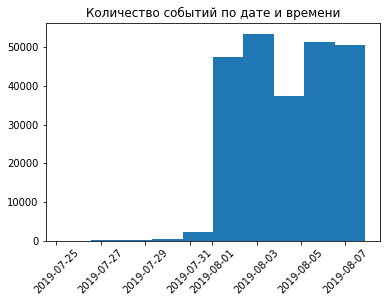

In [20]:
data['event_time'].hist(grid = False, bins = 10)
plt.title('Количество событий по дате и времени')
plt.xticks(rotation = 45)
plt.show()

Данные в базе загружены неравномерно: наиболее полными являются лишь данные с 01 августа по 07 августа. Перенесем данные, обрезанные по этому временному периоду в новый датасет df и посмотрим на количество потерянных при этом записей:

In [21]:
df= data.query('event_time  > "2019-08-01"')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       240887 non-null  object        
 1   user_id          240887 non-null  int64         
 2   event_timestamp  240887 non-null  int64         
 3   group            240887 non-null  object        
 4   event_time       240887 non-null  datetime64[ns]
 5   event_date       240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 12.9+ MB


In [23]:
print('Доля потерь в событиях', round((data['event_name'].count()/df['event_name'].count())*100-100, 2), '%' )
print('Доля потерь в уникальных пользователях', round((data['user_id'].nunique()/df['user_id'].nunique())*100-100, 2), '%' )

Доля потерь в событиях 1.17 %
Доля потерь в уникальных пользователях 0.23 %


In [24]:
for i in ['Main screen', 'Offers screen', 'Cart screen', 'Payment screen', 'Tutorial']:
    print('Доля потерь в событии', i,  \
round((data.query('event_name == @i')['event_name'].count()/df.query('event_name == @i')['event_name'].count())*100-100, 2), '%' )

Доля потерь в событии Main screen 1.51 %
Доля потерь в событии Offers screen 1.03 %
Доля потерь в событии Cart screen 0.86 %
Доля потерь в событии Payment screen 0.59 %
Доля потерь в событии Tutorial 1.29 %


In [25]:
print('Доля потерь в событиях', round((data['event_name'].count()/df['event_name'].count())*100-100, 2), '%' )

Доля потерь в событиях 1.17 %


Потеря данных составила 2826 записи - менее 1,5% от исходного датасета и 17 уникальных пользователей из 7551


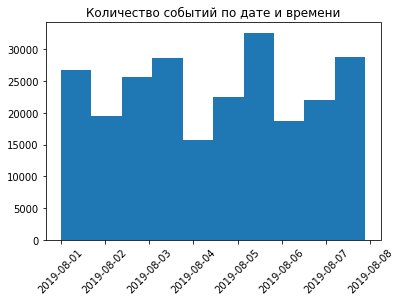

In [26]:
df['event_time'].hist(grid = False)
plt.title('Количество событий по дате и времени')
plt.xticks(rotation = 45)
plt.show()

Проверим что в датасете есть представители всех тестируемых групп:

In [27]:
df['group'].value_counts()

B     84563
A1    79302
A2    77022
Name: group, dtype: int64

Предварительный анализ данных завершен, переходим к анализу воронки событий.

# 3. Анализ воронки событий

Посмотрим какие события есть в логах, как часто они встречаются:

In [28]:
df['event_name'].value_counts()

Main screen       117328
Offers screen      46333
Cart screen        42303
Payment screen     33918
Tutorial            1005
Name: event_name, dtype: int64

Посмотрим сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали событие:

In [29]:
df['user_id'].nunique()  # всего уникальных пользователей

7534

In [30]:
print("В среднем на одного уникального пользователя c период с 1 по 7 августа 2019 г. приходилось", \
      round(df.groupby('user_id')['event_name'].value_counts().mean(), 1), "событий")

В среднем на одного уникального пользователя c период с 1 по 7 августа 2019 г. приходилось 12.0 событий


In [31]:
# сгруппируем датасет по событиям и уникальным пользователям, которые их совершали
# рассчитаем долю пользователей, хоть раз совершавших событие

user_events = df.groupby('event_name')['user_id'].nunique().sort_values(ascending = False).reset_index()
user_events['proportion, %'] = round(user_events['user_id']/df['user_id'].nunique()*100, 2)
user_events

,event_name,user_id,"proportion, %"
0,Main screen,7419,98.47
1,Offers screen,4593,60.96
2,Cart screen,3734,49.56
3,Payment screen,3539,46.97
4,Tutorial,840,11.15


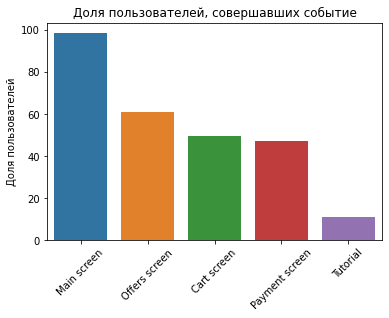

In [32]:
sns.barplot(data=user_events, x = 'event_name', y= 'proportion, %')\
    .set(title = 'Доля пользователей, совершавших событие',xlabel = '', ylabel = "Доля пользователей" )
plt.xticks(rotation = 45) # поворачиваем подписи по оси X для удобного прочтения графика
plt.show()

Проанализируем последовательность событий в воронке событий. За исключение обучения их последовательность соответствует графику выше, а именно "Главный экран" - "Экран оффера" - "Экран корзины" - "Экран успешной оплаты". 

Рассмотрим воронку событий и посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [33]:
# еще раз сгруппируем датасет по событиям и уникальным пользователям
funnel_unique = df.pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'nunique')\
    .reset_index().sort_values(by = 'user_id', ascending = False)
funnel_unique.columns = ['event_name','nunique']
funnel_unique['proportion'] = round(funnel_unique['nunique']/df['user_id'].nunique()*100, 2)

# и рассчитываем долю пользователей от числа пользователей на предыдущем этапе:

funnel_unique['prop_per_previous'] = round(funnel_unique['nunique']/funnel_unique['nunique'].shift(1)*100, 2)
funnel_unique

,event_name,nunique,proportion,prop_per_previous
1,Main screen,7419,98.47,NaN
2,Offers screen,4593,60.96,61.91
0,Cart screen,3734,49.56,81.30
3,Payment screen,3539,46.97,94.78
4,Tutorial,840,11.15,23.74


Экран обучения открывается пользователями при возникновении отдельных вопросов/затруднений и не попадает в общую воронку. Представляется целесообразным исключить его из дальнейшего анализа воронки событий. Визуализируем воронку событий средствами библиотеки plotly:

In [1]:
fig = go.Figure(go.Funnel(
    y = ["Главный экран", "Экран оффера", "Экран корзины", "Экран успешного платежа"],
    x = funnel_unique['nunique'],
    textposition = "inside",
    textinfo = 'value+percent previous',
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"]}
))
fig.update_layout(title={
        'text': "Воронка событий",
        'y':0.9,
        'x':0.5}
)

fig.show()

NameError: name 'go' is not defined

Больше всего пользователей теряется на первом шаге - появление главного экрана. Лишь 62% переходят на экран оффера - потеря составляет 38% пользователей. 
Посмотрим какая доля пользователей доходит от первого события до оплаты:

In [35]:
fig = go.Figure(go.Funnel(
    y = ["Главный экран", "Экран оффера", "Экран корзины", "Экран успешного платежа"],
    x = funnel_unique['nunique'],
    textposition = "inside",
    textinfo = 'value+percent initial',
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"]}
))
fig.update_layout(title={
        'text': "Воронка событий от первого события до оплаты",
        'y':0.9,
        'x':0.5}
)

fig.show()

48% пользователей, увидивших главный экран успешно оплачивают свой заказ. Это чуть меньше половины всех пользователей.

# 4. Результаты эксперимента


Посмотрим распределение пользователей по группам:


In [36]:
groups_qnt = df.groupby('group')['user_id'].nunique()

In [37]:
groups_qnt

group
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

У нас есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим находят ли статистические критерии разницу между выборками А1 и А2. 

Критериями успешного A/A-теста является следующее: 
<br>* Количество пользователей в различных группах различается не более, чем на 1%;
<br>* Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
<br>* Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
<br>* Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

In [38]:
print ('Количество пользователей в различных группах различается на', round(groups_qnt['A2']/groups_qnt['A1']*100 - 100,2 ), '%')

Количество пользователей в различных группах различается на 1.17 %


Этот показатель чуть выше 1%, но разница не является значимой, принимаем решение считать критерий пройденным.

Теперь посмотрим все ли участники A/B-теста попали только в одну группу.

In [39]:
df.groupby('user_id')['group'].nunique().sort_values(ascending = False)

user_id
6888746892508752       1
6204944347213293942    1
6215559225876063378    1
6215162890135937308    1
6213626876710715478    1
                      ..
3171454373076660766    1
3170212200647575044    1
3167974726645136146    1
3167390091686880227    1
9222603179720523844    1
Name: group, Length: 7534, dtype: int64

Все участники попали только в одну группу. 

Определим самые популярные события. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Проверим, будет ли отличие между группами статистически достоверным. 

In [41]:
# сделаем отдельную сводную табличку для дальнейшего анализа, сразу добавим общую контрольную группу A1+A2 

groups_all = df.pivot_table(index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique')\
    .reset_index()
groups_all['A1/A2'] = groups_all['A1'] + groups_all['A2']
groups_all

group,event_name,A1,A2,B,A1/A2
0,Cart screen,1266,1238,1230,2504
1,Main screen,2450,2476,2493,4926
2,Offers screen,1542,1520,1531,3062
3,Payment screen,1200,1158,1181,2358
4,Tutorial,278,283,279,561


Самое популярное событие - главный экран. Рассчитаем будет ли отличие между группами статистически достоверным.

<br> Формулируем нулевую гипотезу H0 - между группами нет отличий в доле пользователей, совершивших событие
<br> Гипотеза H1 - между группами есть отличия в доле пользователей, совершивших событие

In [42]:
alpha = .05 # задаем критический уровень статистической значимости

# считаем количество пользователей, совершивших событие:
successes = [groups_all.query('event_name == "Main screen"')['A1'],groups_all.query('event_name == "Main screen"')\
             ['A2']]
# и сколько всего пользователей в группе:
trials = [groups_qnt['A1'], groups_qnt['A2']]

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  
p_value = (1 - distr.cdf(abs(z_value))) * 2
    # поменяли список событий на вариант без обучения
print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными'
    ) 

p-значение:  [0.75705972]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


Для проверки всех остальных событий сделаем список из всех событий и запустим по нему цикл, который проходится по событиям и подставляет их в расчет:

In [43]:
event_list = list(df['event_name'].unique())
event_list_without_tutorial = ['Main screen', 'Offers screen', 'Cart screen', 'Payment screen']
event_list_without_tutorial

['Main screen', 'Offers screen', 'Cart screen', 'Payment screen']

In [44]:
for i in event_list_without_tutorial:
    alpha = .05 # критический уровень статистической значимости
    successes = [groups_all.query('event_name == @i')['A1'],groups_all.query('event_name == @i')\
             ['A2']]
    trials = [groups_qnt['A1'], groups_qnt['A2']]

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными'
        ) 

p-значение:  [0.75705972]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
p-значение:  [0.24809546]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
p-значение:  [0.22883372]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
p-значение:  [0.11456679]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


Аналогично поступим с группой с изменённым шрифтом B. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. 
Сравним результаты с объединённой контрольной группой. 

In [45]:
# добавим данные по общей контрольной группе в табличку, которая хранит агрегированные данные по общему кол-ву пользователей в группах

groups_qnt.loc['A1/A2'] = groups_qnt[0]+groups_qnt[1]
groups_qnt

group
A1       2484
A2       2513
B        2537
A1/A2    4997
Name: user_id, dtype: int64

Поместим цикл в функцию, аргументами которого будут выступать названия групп и уровень статистической значимости. Тк мы планируем провести множественные тестирования гипотез, то чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез применим метод корректировки уровня значимости - поправку Бонферрони. Для этого уровень значимости alpha на число гипотез. Мы планируем проводить сравнения 4 групп (A1, A2, B и A1+A2) по пяти событиям - соответственно наша поправка Бонферрони будет 20. !Upd - финальный вариант - исключаем tutorial, поправка становится 16
Поправку также добавим в цикло агрументов функции </div>

In [46]:
def stat_check_bonf (group_1, group_2, alpha, bonferroni):
    for i in event_list_without_tutorial:  # поменяли список событий на вариант без обучения
        successes = [groups_all.query('event_name == @i')[group_1],groups_all.query('event_name == @i')\
                 [group_2]]
        trials = [groups_qnt[group_1], groups_qnt[group_2]]

        # пропорция успехов в первой группе:
        p1 = successes[0]/trials[0]

        # пропорция успехов во второй группе:
        p2 = successes[1]/trials[1]

        # пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

        # разница пропорций в датасетах
        difference = p1 - p2 
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)  
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print ('Сравниваем группу', group_1, 'и', group_2, 'событие', i, ':')
        print('p-значение: ', p_value)

        if p_value < alpha/bonferroni:
            print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными'
            ) 

In [47]:
stat_check_bonf ('A1', 'A2', 0.05, 16)

Сравниваем группу A1 и A2 событие Main screen :
p-значение:  [0.75705972]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Сравниваем группу A1 и A2 событие Offers screen :
p-значение:  [0.24809546]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Сравниваем группу A1 и A2 событие Cart screen :
p-значение:  [0.22883372]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Сравниваем группу A1 и A2 событие Payment screen :
p-значение:  [0.11456679]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


Результаты не изменились, даже с применением поправки. Теперь сравним каждую из контрольных групп с группой с измененным шрифтом (B)

In [48]:
stat_check_bonf ('A1', 'B', 0.05, 16)

Сравниваем группу A1 и B событие Main screen :
p-значение:  [0.29497219]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Сравниваем группу A1 и B событие Offers screen :
p-значение:  [0.20836205]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Сравниваем группу A1 и B событие Cart screen :
p-значение:  [0.07842923]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Сравниваем группу A1 и B событие Payment screen :
p-значение:  [0.21225533]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


In [49]:
stat_check_bonf ('A2', 'B', 0.05, 16)

Сравниваем группу A2 и B событие Main screen :
p-значение:  [0.45870536]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Сравниваем группу A2 и B событие Offers screen :
p-значение:  [0.91978178]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Сравниваем группу A2 и B событие Cart screen :
p-значение:  [0.57861979]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Сравниваем группу A2 и B событие Payment screen :
p-значение:  [0.73734151]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


И с объединенной контрольной группой:

In [50]:
stat_check_bonf ('A1/A2', 'B', 0.05, 16)

Сравниваем группу A1/A2 и B событие Main screen :
p-значение:  [0.29424527]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Сравниваем группу A1/A2 и B событие Offers screen :
p-значение:  [0.4342555]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Сравниваем группу A1/A2 и B событие Cart screen :
p-значение:  [0.18175875]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Сравниваем группу A1/A2 и B событие Payment screen :
p-значение:  [0.60042943]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


Всего мы произвели 16 статистических проверок и не одна из из не показала, что можно сделать вывод о различии долей генеральных совокупностей. Изменение шрифта никак не сказалось на дальнейшей конверсии пользователей мобильного приложения.

# 5. Выводы и рекомендации

В результате проведенного исследования предоставленные данные были обработаны и проанализированы. Представляется возможным сделать следующие выводы:
1. В проанализированном за период 1-07.08.2019 логе представлены данные о 240887 событиях в приложении, произведенных 7534 пользователями
2. В среднем один пользователь совершал около 12 действий в приложении
3. Воронка событий выглядит следующим образом: "Главный экран" - "Экран оффера" - "Экран корзины" - "Экран успешной оплаты". Событие "Обучение" является самым малочисленным и выбивается из воронки событий, к обучению пользователи могут обратиться в любой момент, при возникновении сложных ситуаций
4. Самый большой процент потерь наблюдается при переходе с "Главного экрана" - 38% пользователей теряются на этом этапе и не переходят к офферам
5. Примерно половина пользователей проходит полную воронку событий - от "Главного экрана" до "Успешной оплаты"
6. Проведенный A/A/B-эксперимент показал, что изменение шрифтов никак не повлияло на пользовательское поведение. Таким образом опасения менеджеров "отпугнуть клиентов" не оправдались - дизайнеры могут изменить шрифты в приложении. Всего было проведено 16 статистических проверок

**Рекомендации:**
    <br>  До успешной оплаты заказа доходит чуть менее половины пользователей - это не очень высокий показатель, учитывая специфику предмета анализа (пользователь уже установил наше интернет-приложение и зашел в него - уровень заинтересованности велик). Анализ воронки событий позволяет сделать две рекомендации:
1. Для повышения уровня конверсии пользователей приложения рекомендуется обратить внимание на "Экран Оффера" - 38% пользователей теряются при переходе на него с "Главного экрана" - возможно стоит разработать идеи повышения привлекательности этого раздела
2. Обратить внимание на 5% пользователей, которые теряются при переходе от события "Экран корзины" к "Экрану успешной оплаты". Возможно стоит расширить количество возможных методов оплаты, кроме того следует исключить возможность наличия технических неисправностей.
3. Предлагаемое изменение шрифтов в приложении возможно - оно не ухудшит показатели конверсии, но и не улучшит их. Возможно стоит продолжить разработку шрифтов и поискать вариант, который будет способствовать увеличению конверсии пользователей в покупателей.